In [ ]:
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
# import warnings

plt.style.use("ggplot")
# warnings.filterwarnings('ignore')

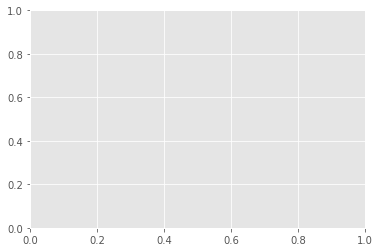

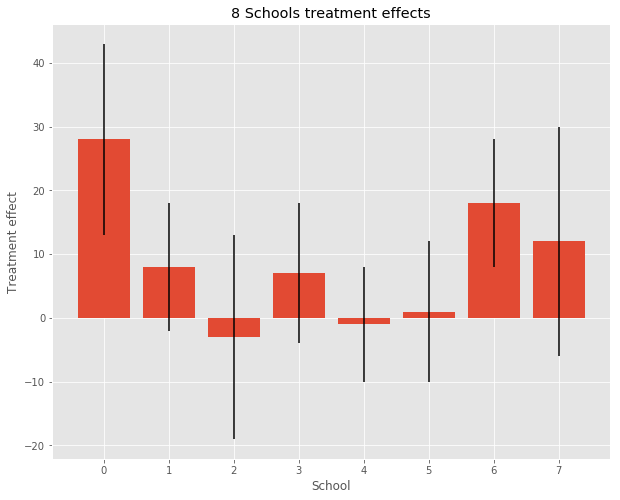

In [5]:
num_schools  = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)  # treatment effects
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)  # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
fig.set_size_inches(10, 8)
plt.show()

# Specify the model

To capture the data, we use a hierarchical normal model. It follows the generative process,

$$\begin{align*}
\mu \sim \textrm{Normal}(0, 10) \\
\log \tau \sim \textrm{Normal}(5, 1) \\
\theta_i \sim \textrm{Normal}(\mu, (e^{\log\tau})^2) \\
y_j \sim \textrm{Normal}(\theta_i, \sigma_{j}^2) \\
\end{align*}$$
where $\mu$ represents the prior average treatment effect and $\tau$ controls how much variance there is between schools. As $\tau \rightarrow \infty$, the model approaches the no-pooling model, i.e., each of the school treatment effect estimates are allowed to be more independent. As $\tau \rightarrow 0$, the model approaches the complete-pooling model, i.e., all of the school treatment effects are closer to the group average $\mu$. To restrict the standard deviation to be positive, we draw $\tau$ from a lognormal distribution (which is equivalent to drawing $log(\tau)$ from a normal distribution).

Following Diagnosing Biased Inference with Divergences, we transform the model above into an equivalent non-centered model:

$$\begin{align*}
\mu \sim \textrm{Normal}(0, 10) \\
\log \tau \sim \textrm{Normal}(5, 1) \\
\theta^{\prime}_{i} \sim \textrm{Normal}(0,1) \\
\theta_i \sim \mu + (e^{\log\tau})\theta^{\prime}_{i} \\
y_j \sim \textrm{Normal}(\theta_i, \sigma_{j}^2) \\
\end{align*}$$
We reify this model as an Edward2 program:

In [7]:
def schools_model(num_schools, treatment_stddevs):
  avg_effect = ed.Normal(loc=0., scale=10., name="avg_effect")  # `mu` above
  avg_stddev = ed.Normal(
      loc=5., scale=1., name="avg_stddev")  # `log(tau)` above
  school_effects_standard = ed.Normal(
      loc=tf.zeros(num_schools),
      scale=tf.ones(num_schools),
      name="school_effects_standard")  # `theta_prime` above
  school_effects = avg_effect + tf.exp(
      avg_stddev) * school_effects_standard  # `theta` above
  treatment_effects = ed.Normal(
      loc=school_effects, scale=treatment_stddevs,
      name="treatment_effects")  # `y` above
  return treatment_effects

# Wrap model in a template. All calls to the model template will use the same
# TensorFlow variables.
model_template = tf.make_template("schools_model", schools_model)
log_joint = ed.make_log_joint_fn(model_template)

In [8]:
def target_log_prob_fn(avg_effect, avg_stddev, school_effects_standard):
  """Unnormalized target density as a function of states."""
  return log_joint(
      num_schools=num_schools,
      treatment_stddevs=treatment_stddevs,
      avg_effect=avg_effect,
      avg_stddev=avg_stddev,
      school_effects_standard=school_effects_standard,
      treatment_effects=treatment_effects)

# Bayesian Inference

## HMC

In [12]:
num_results = 1500
num_burnin_steps = 3000

states, kernel_results = tfp.mcmc.sample_chain( num_results=num_results, 
                                               num_burnin_steps=num_burnin_steps,
                                                current_state=[
                                                tf.zeros([], name='init_avg_effect'),
                                                tf.zeros([], name='init_avg_stddev'),
                                                tf.ones([num_schools], name='init_school_effects_standard'),
                                                ],
                                                kernel=tfp.mcmc.HamiltonianMonteCarlo(
                                                    target_log_prob_fn=target_log_prob_fn,
                                                    step_size=0.4,
                                                    num_leapfrog_steps=3))

avg_effect, avg_stddev, school_effects_standard = states

In [13]:
with tf.Session() as sess:
  [
      avg_effect_,
      avg_stddev_,
      school_effects_standard_,
      is_accepted_,
  ] = sess.run([
      avg_effect,
      avg_stddev,
      school_effects_standard,
      kernel_results.is_accepted,
  ])

school_effects_samples = ( avg_effect_[:, np.newaxis] +np.exp(avg_stddev_)
                          [:, np.newaxis] * school_effects_standard_)
num_accepted = np.sum(is_accepted_)
print('Acceptance rate: {}'.format(num_accepted / num_results))

Acceptance rate: 0.6673333333333333


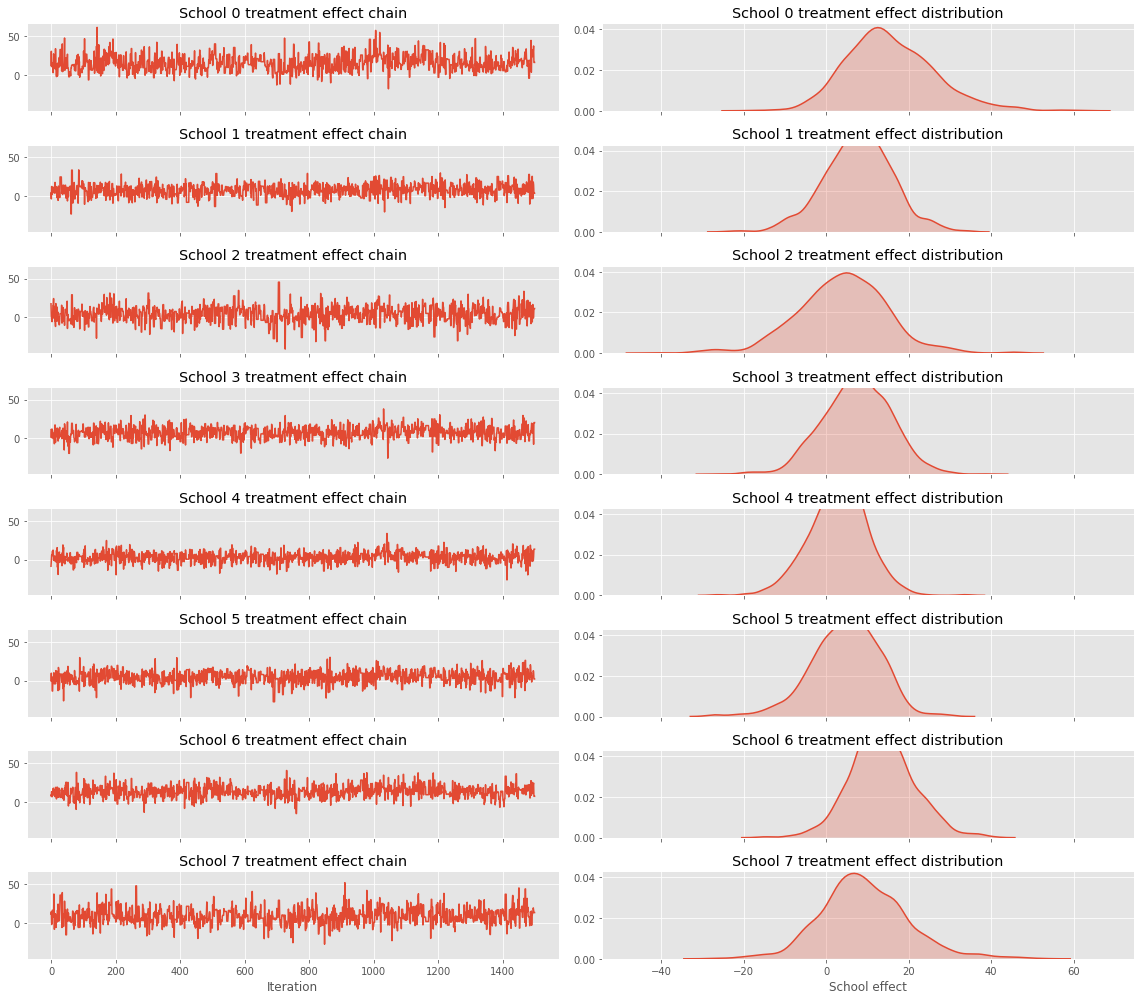

In [15]:
fig, axes = plt.subplots(8, 2, sharex='col', sharey='col')
fig.set_size_inches(16, 14)
for i in range(num_schools):
  axes[i][0].plot(school_effects_samples[:,i])
  axes[i][0].title.set_text("School {} treatment effect chain".format(i))
  sns.kdeplot(school_effects_samples[:,i], ax=axes[i][1], shade=True)
  axes[i][1].title.set_text("School {} treatment effect distribution".format(i))
axes[num_schools - 1][0].set_xlabel("Iteration")
axes[num_schools - 1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()

In [16]:
print("E[avg_effect] = {}".format(avg_effect_.mean()))
print("E[avg_stddev] = {}".format(avg_stddev_.mean()))
print("E[school_effects_standard] =")
print(school_effects_standard_[:, ].mean(0))
print("E[school_effects] =")
print(school_effects_samples[:, ].mean(0))

E[avg_effect] = 8.072097778320312
E[avg_stddev] = 2.377455711364746
E[school_effects_standard] =
[ 0.60185117 -0.00410498 -0.32525966 -0.05824095 -0.45326209 -0.25851887
  0.4796266   0.09136151]
E[school_effects] =
[ 15.49308491   7.78996038   3.90553713   7.44813013   2.96708846
   4.75392199  13.55749702   9.23515034]


In [17]:
# Compute the 95% interval for school_effects
school_effects_low = np.array([
    np.percentile(school_effects_samples[:, i], 2.5) for i in range(num_schools)
])
school_effects_med = np.array([
    np.percentile(school_effects_samples[:, i], 50) for i in range(num_schools)
])
school_effects_hi = np.array([
    np.percentile(school_effects_samples[:, i], 97.5)
    for i in range(num_schools)
])

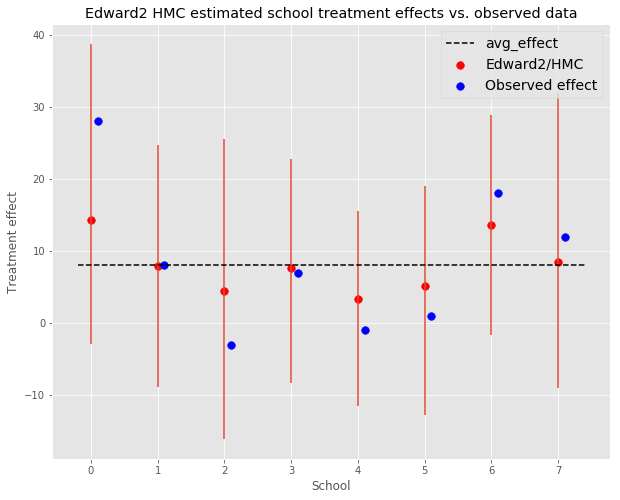

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
ax.scatter(np.array(range(num_schools)), school_effects_med, color='red', s=60)
ax.scatter(
    np.array(range(num_schools)) + 0.1, treatment_effects, color='blue', s=60)

avg_effect = avg_effect_.mean()

plt.plot([-0.2, 7.4], [avg_effect, avg_effect], 'k', linestyle='--')

ax.errorbar(
    np.array(range(8)),
    school_effects_med,
    yerr=[
        school_effects_med - school_effects_low,
        school_effects_hi - school_effects_med
    ],
    fmt='none')

ax.legend(('avg_effect', 'Edward2/HMC', 'Observed effect'), fontsize=14)

plt.xlabel('School')
plt.ylabel('Treatment effect')
plt.title('Edward2 HMC estimated school treatment effects vs. observed data')
fig.set_size_inches(10, 8)
plt.show()

In [20]:
print("Inferred posterior mean: {0:.2f}".format(
    np.mean(school_effects_samples[:,])))
print("Inferred posterior mean sd: {0:.2f}".format(
    np.std(school_effects_samples[:,])))

Inferred posterior mean: 8.14
Inferred posterior mean sd: 9.90


## Variational Inference

In [25]:
help(tfp.vi.kl_reverse)

Help on function kl_reverse in module tensorflow_probability.python.vi.csiszar_divergence:

kl_reverse(logu, self_normalized=False, name=None)
    The reverse Kullback-Leibler Csiszar-function in log-space.
    
    A Csiszar-function is a member of,
    
    ```none
    F = { f:R_+ to R : f convex }.
    ```
    
    When `self_normalized = True`, the KL-reverse Csiszar-function is:
    
    ```none
    f(u) = -log(u) + (u - 1)
    ```
    
    When `self_normalized = False` the `(u - 1)` term is omitted.
    
    Observe that as an f-Divergence, this Csiszar-function implies:
    
    ```none
    D_f[p, q] = KL[q, p]
    ```
    
    The KL is "reverse" because in maximum likelihood we think of minimizing `q`
    as in `KL[p, q]`.
    
    calculations and may therefore be numerically unstable for `|logu| >> 0`.
    
    Args:
      logu: `float`-like `Tensor` representing `log(u)` from above.
      self_normalized: Python `bool` indicating whether `f'(u=1)=0`. When
        `f'(u=1)=